# Training ADHunter on TREBL-seq data
GOAL: Transfer learn to predict $t_{1/2}$ from TREBL-seq using transfer learning from my Gcn4 model 

In [2]:
%load_ext autoreload
%autoreload 2 

%matplotlib inline

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")
sns.set_context("notebook")

from sklearn import preprocessing
import pytorch_lightning as pl
from actpred.models import ActCNNSystem
from actpred.utils import get_threshold, get_stratified_split

from scipy.stats import spearmanr
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import CSVLogger, WandbLogger
import os
from Bio.Seq import Seq

pl.seed_everything(0)

Global seed set to 0


0

In [3]:
df = pd.read_csv("../data/EC_TREBLactivities_20250321_v2.csv")
df["AAseq"] = df["Tile"].apply(lambda seq: "".join(Seq(seq).translate()))
# print(sum(df[df["AAseq"].str.len() == 40]) / len(df))
df = df[df["AAseq"].str.len() == 40]
df = df.loc[df.loc[:, ['AAseq', 'Vmax']].drop_duplicates().index]
# FILTER OUT SOME OUTLIERS
# df = df.loc[df["Vmax"] <= 2000]
# df_ad = df[df["Activity"]=="active"].copy()

seqs = df["AAseq"].to_numpy()

vmax = df["Vmax"].to_numpy().reshape(-1, 1)
vmax_scaler = preprocessing.StandardScaler().fit(vmax)
y_cont = vmax_scaler.transform(vmax)
y_bin = (df["Activity"]=="active").values

# convert seqs to integer valued vectors
alphabet="ACDEFGHIKLMNPQRSTVWY"
aa_to_i = {aa:i for i, aa in enumerate(alphabet)}
i_to_aa = {i:aa for i, aa in enumerate(alphabet)}
X = np.asarray([[aa_to_i[aa] for aa in x] for x in seqs])

# train, val, test, indices = get_stratified_split(X, y_bin, y_cont, as_tensor=True)
# (X_train, y_bin_train, y_cont_train) = train
# (X_val, y_bin_val, y_cont_val) = val
# (X_test, y_bin_test, y_cont_test) = test
# test_idx, val_idx = indices

In [4]:
fn = "../data/OrthologTilingDFwActivities_20240930.csv"
df_gcn4 = pd.read_csv(fn)
df_gcn4["Activity"] = df_gcn4["Activity"].fillna(0.0)
df_gcn4 = df_gcn4.loc[df_gcn4.Activity != 0.0]
df_gcn4 = df_gcn4.iloc[:, 1:]
df_gcn4 = df_gcn4.loc[df_gcn4.loc[:, ['Seq', 'Activity']].drop_duplicates().index]
df_gcn4 = df_gcn4.dropna(subset=df_gcn4.columns[:-1], axis=0)
df_gcn4.rename(columns={"Seq": "AAseq"}, inplace=True)

In [5]:
# print(df.shape, df_gcn4.shape)
df_m = pd.merge(df, df_gcn4, on="AAseq", suffixes=["_trebl", "_gcn4"]).sort_values(by="SpeciesNames")
df_m["SpeciesNames"].value_counts()
df_m

,Unnamed: 0,level_0,index,Tile,0,5,10,15,30,180,...,Vmax,Avg_StdDev,Activity_trebl,T1/2,AAseq,SpeciesNames,NativeLocation,NormLocation,Activity_gcn4,Stdev_BYS4_BioReps
6208,6816,6816.0,8930.0,TGTGCTGATAATTTGGATCATGAAGCTTTGGCTAAATTGGAAAGAT...,1.869771,1.684966,2.396765,3.071105,6.781861,4.445828,...,6.781861,1.133052,inactive,20.071922,CADNLDHEALAKLERSVPIFSESKRSTDLDSAVENFFGSS,Aace_AGO11762.1_SaccharomycetaceaeAshbyaAceri,95,-40,57975.801772,NaN
8711,1802,NaN,NaN,TCTACTGATTTGGATTCTGCTGTTGAGAACTTCTTTGGTTCTTCTT...,0.360111,4.120431,8.676081,11.721410,12.898664,13.449345,...,13.449345,0.673327,active,8.055872,STDLDSAVENFFGSSSDSTPLFEFEGLGKTTDPKTWSSLF,Aace_AGO11762.1_SaccharomycetaceaeAshbyaAceri,120,-15,262143.000000,NaN
3486,3845,3845.0,5010.0,GATGATGATATTCCAGTTACTTTGGAAGATGTTTCTTCTGTTGAAT...,0.771502,1.196932,1.461367,1.401682,1.797814,2.458455,...,2.766239,0.366730,inactive,28.904043,DDDIPVTLEDVSSVESITTAAGTESCFLPTPVIEDAVLKP,Aace_AGO11762.1_SaccharomycetaceaeAshbyaAceri,160,25,27507.854931,8129.650758
8192,1233,NaN,NaN,GATTCTTCTACTTTGTTGGGTGAATTGGTCTTTGAGAAATTTGCTT...,8.189316,12.331172,24.907915,28.358881,28.819346,32.426365,...,33.807622,7.853790,active,8.445764,DSSTLLGELVFEKFACADNLDHEALAKLERSVPIFSESKR,Aace_AGO11762.1_SaccharomycetaceaeAshbyaAceri,80,-55,39050.457842,NaN
1327,1460,1460.0,1870.0,AGATCTAGAGCTAGGAAATTGGAAAGAATGAATCAATTGGAAGAAA...,1.087008,1.274194,1.345518,1.569291,2.202728,1.737806,...,2.202728,0.191090,inactive,16.789675,RSRARKLERMNQLEERVEQLLQKNSELEAEVARLKSLVAS,Aace_AGO11762.1_SaccharomycetaceaeAshbyaAceri,295,160,38260.000000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8029,1052,NaN,NaN,GAATTGGCTACTGGTTCTTCTGATGTTGACTTTGGTATTGCTGTTG...,1.025763,1.992462,2.292184,3.320655,4.622469,5.589385,...,6.508497,0.594638,active,20.144452,ELATGSSDVDFGIAVDSVPEFPVSEIPAPVSDFVLPTPQP,Zyro_ZYRO0D09174g,95,49,77011.151583,9175.996282
6928,7594,7594.0,9997.0,TTTCCAGTTTCTGAAATTCCAGCTCCAGTTTCTGACTTTGTCTTGC...,1.305091,1.702839,1.418786,1.270543,1.898598,1.389288,...,1.898598,0.298324,inactive,3.730421,FPVSEIPAPVSDFVLPTPQPDPKPRSRASRVSKVDKLGVV,Zyro_ZYRO0D09174g,115,69,35309.754949,NaN
3308,3647,3647.0,4723.0,GACCCTAAACCAAGATCTAGAGCTTCTAGAGTTTCTAAAGTTGATA...,1.351857,1.335420,1.559650,1.518138,1.399057,1.521093,...,1.559650,0.209904,inactive,7.683261,DPKPRSRASRVSKVDKLGVVSYNRKNRNAPLTPVLCESDD,Zyro_ZYRO0D09174g,135,89,40071.367050,6777.409057
5303,5820,5820.0,7650.0,TCTAGAGCTTCTAGAGTTTCTAAAGTTGATAAATTGGGTGTTGTTT...,0.730181,0.803581,0.801622,0.889091,0.906091,1.126745,...,1.126745,0.156221,inactive,45.208684,SRASRVSKVDKLGVVSYNRKNRNAPLTPVLCESDDPVAMK,Zyro_ZYRO0D09174g,140,94,32897.910369,857.798028


/var/folders/1w/3zhjqj3d3ljgvrrqp77lpv6m0000gn/T/ipykernel_9283/2078765266.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(frameon=False, loc="upper right")


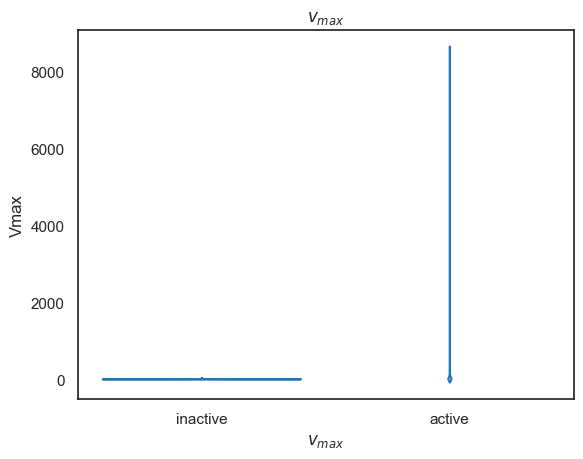

In [6]:
sns.violinplot(df, y="Vmax", x="Activity", inner=None, fill=None)
# sns.displot(vmax, kind='kde')
# # for t in df.columns[4:11].astype(int):
# #     plt.axvline(t, linewidth=1, c='k', alpha=0.3, linestyle="dotted")
# # plt.yscale("log")
# # plt.xscale("log")
# # plt.axvline(t_half_median, c='r', linewidth=1, alpha=0.8, label="Median")
# # plt.axvline(np.mean(vmax), c='m', linewidth=1, alpha=0.8, label="Mean")
plt.xlabel("$v_{max}$")
plt.title("$v_{max}$")
plt.legend(frameon=False, loc="upper right")
plt.show()

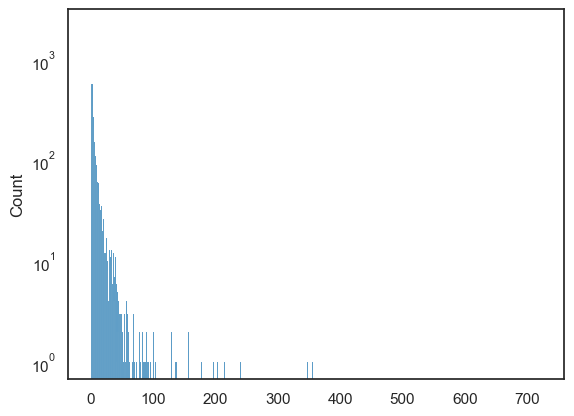

In [7]:
sns.histplot(vmax[vmax < 2000])
plt.yscale("log")
plt.show()

In [8]:
train, val, test, indices = get_stratified_split(X, y_bin, y_cont, as_tensor=True)
(X_train, y_bin_train, y_cont_train) = train
(X_val, y_bin_val, y_cont_val) = val
(X_test, y_bin_test, y_cont_test) = test
test_idx, val_idx = indices

In [9]:
# Code to split based on t1/2 and X alone with no stratification; 
# I don't think models trained with this sort of split are very consistent

# from sklearn.model_selection import ShuffleSplit, StratifiedShuffleSplit

# splitter = ShuffleSplit(n_splits=1,
#                         train_size=0.8,
#                         random_state=0)
# train_index, val_test_index = list(splitter.split(X, y_cont))[0]
# X_train = X[train_index]
# y_cont_train = y_cont[train_index]

# X_val_test = X[val_test_index]
# y_cont_val_test = y_cont[val_test_index]

# splitter = ShuffleSplit(n_splits=1,
#                         train_size=0.5,
#                         random_state=0)
# val_index, test_index = list(splitter.split(X_val_test, y_cont_val_test))[0]
# X_val = X_val_test[val_index]
# y_cont_val = y_cont_val_test[val_index]
# X_test = X_val_test[test_index]
# y_cont_test = y_cont_val_test[test_index]

# # Convert everything to tensors
# X_train = torch.tensor(X_train)
# y_cont_train = torch.tensor(y_cont_train)
# X_val = torch.tensor(X_val)
# y_cont_val = torch.tensor(y_cont_val)
# X_test = torch.tensor(X_test)
# y_cont_test = torch.tensor(y_cont_test)

In [10]:
# Create Training and Validation Datasets
bs = 128
train_ds = TensorDataset(X_train, y_cont_train.to(torch.float))
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

val_ds = TensorDataset(X_val, y_cont_val.to(torch.float))
val_dl = DataLoader(val_ds, batch_size=bs)

In [11]:
# import copy

kernel_size = 5
dilation = 3 
hidden = 64

model = ActCNNSystem(hidden, kernel_size, dilation, num_res_blocks=3)
model.load_state_dict(torch.load("../adhunter/adhunter_1he.pt"))
# model.eval()

/opt/homebrew/Caskroom/miniconda/base/envs/adhunter/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `SpearmanCorrcoef` will save all targets and predictions in the buffer. For large datasets, this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


<All keys matched successfully>

In [12]:
dirpath="../misc/models"
csv_logger = CSVLogger('../misc/logs')
checkpoint_callback = ModelCheckpoint(dirpath=dirpath, monitor="val_loss", filename="min_val_loss", save_last=True)
patience=10
early_stopping = EarlyStopping('val_loss', patience=patience)

trainer = pl.Trainer(accelerator="gpu", devices=1, callbacks=[checkpoint_callback, early_stopping], logger=[csv_logger], max_epochs=100)
trainer.fit(model, train_dataloaders=train_dl, val_dataloaders=val_dl)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/homebrew/Caskroom/miniconda/base/envs/adhunter/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:612: UserWarning: Checkpoint directory ../misc/models exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | ActCNN           | 96.8 K
1 | loss_fn   | MSELoss          | 0     
2 | rmse      | MeanSquaredError | 0     
3 | pearsonr  | PearsonCorrCoef  | 0     
4 | spearmanr | SpearmanCorrCoef | 0     
-----------------------------------------------
96.8 K    Trainable params
0         Non-trainable params
96.8 K    Total params
0.387     Total estimated model params size (MB)


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/opt/homebrew/Caskroom/miniconda/base/envs/adhunter/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 25.61it/s]val_rmse 0.7908585071563721
val_pearsonr 0.263672411441803
val_spearmanr 0.7062007188796997


/opt/homebrew/Caskroom/miniconda/base/envs/adhunter/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0: 100%|██████████| 72/72 [00:01<00:00, 50.54it/s, loss=0.0591, v_num=46]val_rmse 0.9767392873764038
val_pearsonr 0.18875831365585327
val_spearmanr 0.6202174425125122
Epoch 1: 100%|██████████| 72/72 [00:00<00:00, 80.83it/s, loss=2.83, v_num=46]  val_rmse 0.9718255400657654
val_pearsonr 0.19602641463279724
val_spearmanr 0.6404220461845398
Epoch 2: 100%|██████████| 72/72 [00:00<00:00, 74.79it/s, loss=3.24, v_num=46]  val_rmse 0.9992157220840454
val_pearsonr 0.1556566208600998
val_spearmanr 0.5504000186920166
Epoch 3: 100%|██████████| 72/72 [00:00<00:00, 79.55it/s, loss=0.0381, v_num=46]val_rmse 0.9752337336540222
val_pearsonr 0.18910787999629974
val_spearmanr 0.5283265709877014
Epoch 4: 100%|██████████| 72/72 [00:01<00:00, 59.74it/s, loss=2.93, v_num=46]  val_rmse 1.0904887914657593
val_pearsonr 0.11324460059404373
val_spearmanr 0.5133343935012817
Epoch 5: 100%|██████████| 72/72 [00:00<00:00, 83.61it/s, loss=0.183, v_num=46] val_rmse 0.9783021807670593
val_pearsonr 0.15613093972206

In [13]:
# Load the best model
ckpt_dict = torch.load(checkpoint_callback.best_model_path)
model.load_state_dict(ckpt_dict["state_dict"])


<All keys matched successfully>

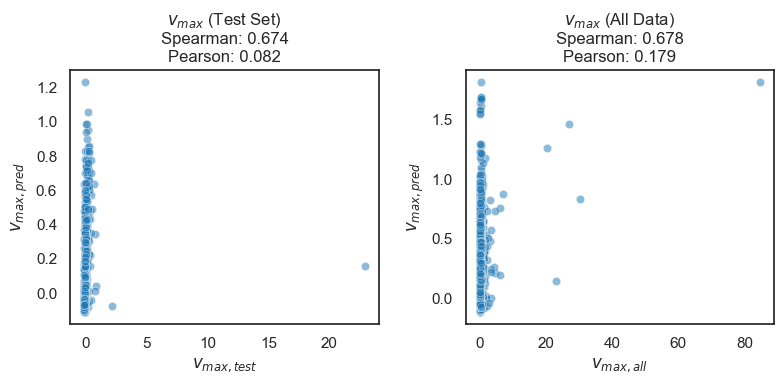

In [14]:
from scipy.stats import pearsonr, spearmanr
sns.set_style("white")
sns.set_context("notebook")

y_pred = model(X_test).detach().numpy().flatten()
y_te = y_cont_test.detach().numpy().flatten()


fig, axs = plt.subplots(1, 2, figsize=(8, 4))
# sns.scatterplot(x=y_te[:, 0].flatten(), y=y_pred[:, 0].flatten(), alpha=.5, ax=axs[0])
# axs[0].set_xlabel("$V_{max, test}$")
# axs[0].set_ylabel("$V_{max, pred}$")
# spearman0 = spearmanr(y_te[:, 0].flatten(), y_pred[:, 0].flatten()).statistic.round(3)
# pearson0 = pearsonr(y_te[:, 0].flatten(), y_pred[:, 0].flatten()).statistic.round(3)

# axs[0].set_title("$V_{max}$\n" + f"Spearman: {spearman0}\nPearson: {pearson0}")

sns.scatterplot(x=y_te, y=y_pred, alpha=.5, ax=axs[0])
axs[0].set_xlabel("$v_{max, test}$")
axs[0].set_ylabel("$v_{max, pred}$")
spearman0 = spearmanr(y_te, y_pred).statistic.round(3)
pearson0 = pearsonr(y_te, y_pred).statistic.round(3)
axs[0].set_title("$v_{max}$ (Test Set)\n" + f"Spearman: {spearman0}\nPearson: {pearson0}")

# fig.tight_layout()
# plt.show()

y_all_pred = model(torch.tensor(X)).detach().numpy().flatten()
y_all = y_cont.flatten()
# fig, ax = plt.subplots()
sns.scatterplot(x=y_all, y=y_all_pred, alpha=.5, ax=axs[1])
axs[1].set_xlabel("$v_{max, all}$")
axs[1].set_ylabel("$v_{max, pred}$")
spearman1 = spearmanr(y_all, y_all_pred).statistic.round(3)
pearson1 = pearsonr(y_all, y_all_pred).statistic.round(3)
axs[1].set_title("$v_{max}$ (All Data)\n" + f"Spearman: {spearman1}\nPearson: {pearson1}")

fig.tight_layout()
plt.show()

In [16]:
df["Activity"].value_counts()

Activity
inactive    7715
active      2481
Name: count, dtype: int64